In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from pycaret import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
# load in the datasets from the ai_ready data folder found on the GoogleDrive : https://drive.google.com/drive/folders/1PMfDE_NcJCksiyA4KFzyt387RP2d4bcR?usp=drive_link

cod_ds = xr.open_dataset('CloudOpticalDepth_remapped.nc')
rsw_ds = xr.open_dataset('ReflectedSW_remapped.nc')
gray_ds = xr.open_dataset('GrayImagery_remapped.nc')

In [3]:
# get the values from each of the three main variables in each loaded dataset

COD = cod_ds['CloudOpticalDepth'].values 
CID = gray_ds['GrayImagery'].values
RSW = rsw_ds['ReflectedSW'].values

In [4]:
# flatten the arrays to manageable 1 dimensional arrays

COD = COD.flatten()
CID = CID.flatten()
RSW = RSW.flatten()

In [5]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# basic tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

# classifiers from sklearns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [6]:
# preparing the data for cluster analysis, we will also attempt a time series analysis (one should keep in mind that we onlyhave 10 days)

times = cod_ds.time.values
time3, lat_remapped3, lon_remapped3 = np.meshgrid(cod_ds.time.values,cod_ds.latitude.values,cod_ds.longitude.values,indexing='ij')
df = pd.DataFrame({'time':time3.flatten(),'lon':lon_remapped3.flatten(),'lat':lat_remapped3.flatten(),'COD': COD, 'CID': CID, 'RSW': RSW})

df.dropna(inplace=True)
df = df.loc[~((df.COD==0))]

data = df[['COD','CID','RSW']].values

df0 = df.loc[df.time==times[0]]
data0 = df0[['COD','CID','RSW']].values

correlation_matrix = df0[['COD', 'CID', 'RSW']].corr() # correlation matrix at time 0
correlation_matrix.style.background_gradient()

,COD,CID,RSW
COD,1.000000,0.710919,0.653336
CID,0.710919,1.000000,0.895426
RSW,0.653336,0.895426,1.000000


In [7]:
# This is to predict cloud optical depth from reflected shortwave and cloud imagery

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate features and target variable
y = df0['COD']  # Cloud Optical Depth as the target
X = df0.drop(columns=['COD'])  # Remaining features as predictors

# Define the regression model
clf = LinearRegression()

# Normalize features
X = StandardScaler().fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Calculate the mean accuracy (R^2 score) on the test set
score = clf.score(X_test, y_test)
print("The R^2 score on the test data is %f" % score)


The R^2 score on the test data is 0.513179


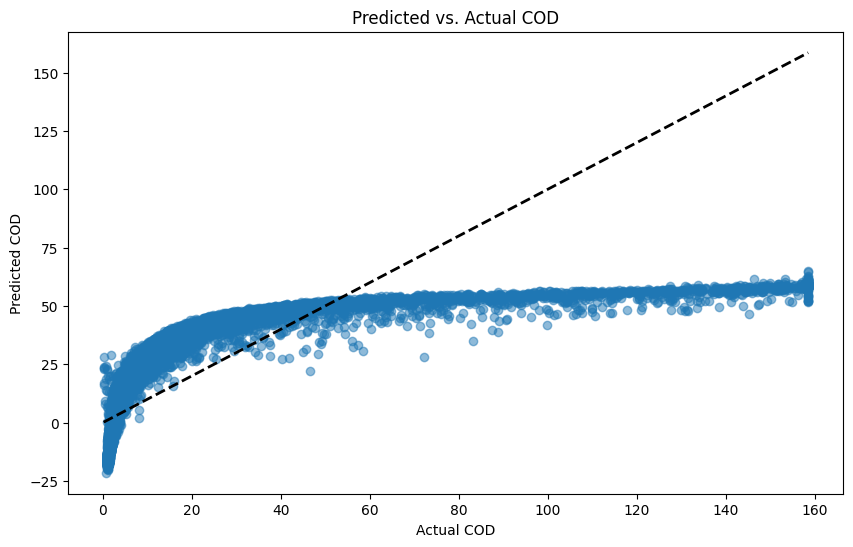

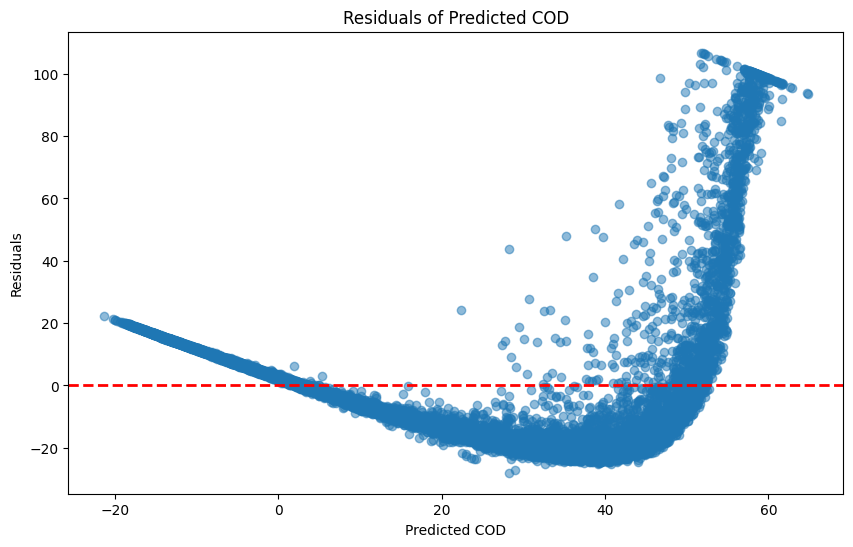

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict COD values for the test set
y_pred = clf.predict(X_test)

# Plot 1: Predicted vs. Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual COD')
plt.ylabel('Predicted COD')
plt.title('Predicted vs. Actual COD')
plt.show()

# Plot 2: Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted COD')
plt.ylabel('Residuals')
plt.title('Residuals of Predicted COD')
plt.show()


In [9]:
from pycaret.regression import *

s_regress = setup(df0, target='COD', session_id=123)



,Description,Value
0,Session id,123
1,Target,COD
2,Target type,Regression
3,Original data shape,"(35828, 6)"
4,Transformed data shape,"(35828, 6)"
5,Transformed train set shape,"(25079, 6)"
6,Transformed test set shape,"(10749, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [10]:
best_regress = compare_models(include=[
    'lr',       # Linear Regression
    'lasso',    # Lasso Regression
    'ridge',    # Ridge Regression
    'en',       # Elastic Net
    'lar',      # Least Angle Regression
    'llar',     # Lasso Least Angle Regression
    'omp',      # Orthogonal Matching Pursuit
    'br',       # Bayesian Ridge
    'ard',      # Automatic Relevance Determination
    'par',      # Passive Aggressive Regressor
    'ransac',   # RANSAC Regressor
    'tr',       # TheilSen Regressor
    'huber',    # Huber Regressor
    # 'kr',       # Kernel Ridge
    'svm',      # Support Vector Machine
    'knn',      # K-Nearest Neighbors
    'dt',       # Decision Tree
    'ada',      # AdaBoost Regressor
    'gbr',      # Gradient Boosting Regressor
    'mlp',      # Multi-layer Perceptron
    'lightgbm', # LightGBM
], fold=3)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.8270,23.2248,4.8180,0.9736,0.1479,0.1319,0.1333
gbr,Gradient Boosting Regressor,2.2245,31.3656,5.6002,0.9644,0.1824,0.1792,1.9033
dt,Decision Tree Regressor,2.4839,48.8544,6.9893,0.9445,0.1893,0.1413,0.1133
ada,AdaBoost Regressor,6.8112,115.1551,10.7051,0.8692,0.5197,0.8624,0.4600
mlp,MLP Regressor,7.5865,185.5713,13.6103,0.7894,0.5586,1.0324,14.9533
knn,K Neighbors Regressor,8.8224,388.2881,19.7028,0.5591,0.5548,0.6651,0.0467
lr,Linear Regression,13.7592,428.4670,20.6994,0.5135,0.9319,2.6103,0.0167
ridge,Ridge Regression,13.7177,428.5005,20.7002,0.5135,0.9275,2.5866,0.0167
lar,Least Angle Regression,13.7592,428.4670,20.6994,0.5135,0.9319,2.6103,0.0167
br,Bayesian Ridge,13.7565,428.4671,20.6994,0.5135,0.9316,2.6088,0.0167


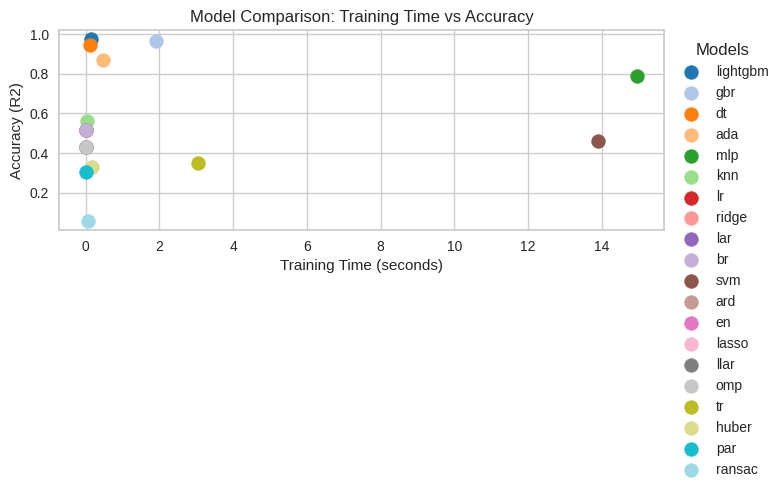

In [11]:
from pycaret.regression import compare_models, pull
import matplotlib.pyplot as plt


results_df = pull() 

tt = results_df['TT (Sec)']          
accuracy = results_df['R2']     
model_names = results_df.index   

plt.figure(figsize=(8, 4))

colors = plt.cm.tab20(range(len(model_names))) 

for i, model in enumerate(model_names):
    plt.scatter(tt[i], accuracy[i], color=colors[i], label=model, s=100)

# Customize plot
plt.title('Model Comparison: Training Time vs Accuracy')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy (R2)')
plt.grid(True)

# Adding legend
plt.legend(title="Models", bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()  
plt.show()


Beginning with the simplest model evaluation, before tuning anything. We see the most accurate models are the Light Gradient Boosting Machine, the Gradient Boosting Regressor, and the Decision Tree Regressor. The top two for speed are the Ridge Regression and the Lasso Regression. With increased speed does not necessarily mean increased or decreased accuracy. The models that took the longest to run, MLP Regressor and Support Vector Regression did not have the highest accuracy as expected. The Light Gradient Boosting is chosen as the best model, we will tune the "best model" in the follwoing section.

For the checking of parameters and tuning we will focus on the Light Gradient Boosting Machine.

In [19]:
tuned_model = tune_model(best_regress) # set up own models in sci kit learn for better analysis.

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3253,28.8650,5.3726,0.9701,0.2033,0.1813
1,2.1179,23.9115,4.8899,0.9713,0.1965,0.1674
2,2.0717,24.0584,4.9049,0.9723,0.1908,0.1604
3,1.9314,21.2146,4.6059,0.9736,0.1895,0.1635
4,2.1311,25.4176,5.0416,0.9726,0.1948,0.1787
5,2.1714,27.5216,5.2461,0.9695,0.1857,0.1648
6,2.0911,26.3929,5.1374,0.9698,0.1906,0.1567
7,2.0959,24.3869,4.9383,0.9705,0.1771,0.1535
8,2.1105,26.3986,5.1380,0.9720,0.1982,0.1760


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in 

The tuned models in fact performed worse than the original model, and thus we maintain the original model for analysis.

However, since we know the best model to use, it may be better to create our own lgb models and input our own parameters.

In [21]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time

# Sample dataset (replace with your own data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an LGBMRegressor with custom parameters
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    verbose=-1
)

# Measure training time
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

# Calculate and print training time
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Training Time: 0.17 seconds
Mean Squared Error: 20.461471901226172


In [22]:
from sklearn.model_selection import GridSearchCV
import time

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.7, 0.8, 1.0]
}

# Set up GridSearchCV with LGBMRegressor
grid_search = GridSearchCV(
    estimator=LGBMRegressor(verbose=-1),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Measure the tuning time
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Calculate and print tuning time
tuning_time = end_time - start_time
print(f"Hyperparameter Tuning Time: {tuning_time:.2f} seconds")

# Retrieve the best model and parameters
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)


Hyperparameter Tuning Time: 163.25 seconds
Best parameters found: {'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}


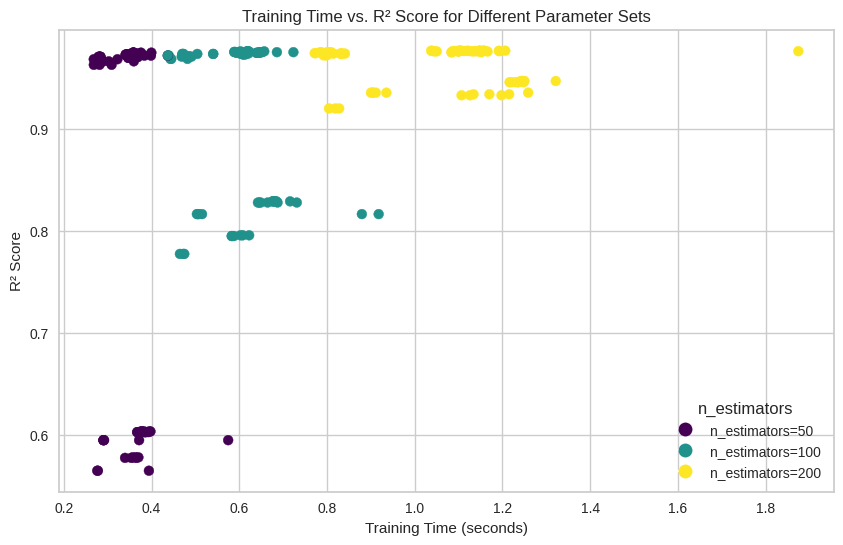

In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib.lines import Line2D

# Sample dataset (replace with your own data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.7, 0.8, 1.0]
}

# Lists to store training times and R² scores
training_times = []
r2_scores = []
parameter_sets = []
colors = []

# Choose parameter for grouping (e.g., n_estimators)
grouping_param = 'n_estimators'
unique_values = sorted(set(param_grid[grouping_param]))
color_map = plt.cm.get_cmap('viridis', len(unique_values))

# Iterate over each combination of parameters
for params in ParameterGrid(param_grid):
    # Create a model with the current parameters
    model = LGBMRegressor(**params, verbose=-1)
    
    # Measure training time
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)  # Using R² as the scoring metric
    end_time = time.time()
    
    # Store the training time, mean R² score, and parameters
    training_time = end_time - start_time
    mean_r2_score = np.mean(scores)
    
    training_times.append(training_time)
    r2_scores.append(mean_r2_score)
    parameter_sets.append(params)
    
    # Assign a color based on the grouping parameter
    param_value = params[grouping_param]
    color_idx = unique_values.index(param_value)
    colors.append(color_map(color_idx))

# Plot Training Time vs. R² Score with color coding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(training_times, r2_scores, color=colors, s=50)
plt.title("Training Time vs. R² Score for Different Parameter Sets")
plt.xlabel("Training Time (seconds)")
plt.ylabel("R² Score")
plt.grid(True)

# Create a legend for the grouping parameter
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i), markersize=10, label=f"{grouping_param}={unique_values[i]}")
    for i in range(len(unique_values))
]
plt.legend(handles=legend_elements, title=grouping_param)

plt.show()


As we can see when we increase the number of estimators we increase training time and the average $R^2$ score. When n is 50 we can achieve a high $R^2$ score however, we need to be sure we are tuning other aspects of the model to ensure the best results. The best combination of parameters is: {'bagging_fraction': 0.7, 'feature_fraction': 0.9, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}


**Real World Application**

The idea for the project presently is to predict cloud fraction or precipitation from a number of cloud controlling factors, here we only look at two factors and try to predict a third. The two predictors are reflected shortwave and cloud brightness or grayscale imagery the target variable then is cloud optical depth. 

Clouds are one of the largest sources of uncertainty in climate modeling, being able to accurately predict and conrol for precipiation or cloud fraction would be a huge step forward for the community. Right now we see the expected results given the two predictors, the reflecteds